In [16]:
# 2. Classify flower species based on flower morphology (iris dataset)
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [11]:
# load and explore data
iris = datasets.load_iris()
print(iris.keys())
print(iris.feature_names)
print(iris.data[0:6, :])
print(iris.target_names)
print(iris.target[0:6])

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename'])
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]
 [5.4 3.9 1.7 0.4]]
['setosa' 'versicolor' 'virginica']
[0 0 0 0 0 0]


In [12]:
# feature engineering
irisdf = pd.DataFrame(iris.data, columns=iris.feature_names)
irisdf = irisdf[~irisdf.isnull().any(axis=1)]
irisdf.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


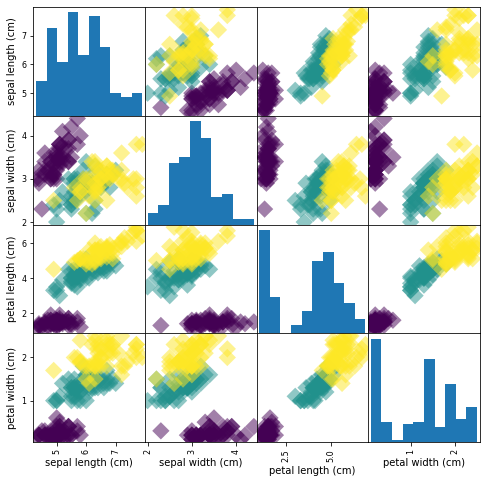

In [13]:
# correlation matrix for visual exploration
pd.plotting.scatter_matrix(irisdf, c=iris.target, figsize=[8, 8], s=150, marker='D')
plt.show()

In [17]:
# run grid search cross validation for random forest classifier:

# store full data in new structures
X = irisdf.copy()
y = iris.target.copy()

# make stratified training and hold-out test sets
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.2, random_state=1, stratify=y)

# parameter grid
pars = {'n_estimators': range(20, 81), 'min_samples_split': range(2, 11), 'max_samples': range(1, 5)} 

# instantiate classifier and grid search object
rfor = RandomForestClassifier(random_state=1)
 
 # use stratified 5-fold cross-validation
clf = GridSearchCV(
    rfor, 
    pars, 
    scoring='accuracy', 
    cv=3, 
    return_train_score=True, 
    refit=True)

# train model
clf.fit(Xtrain, ytrain)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=1),
             param_grid={'max_samples': range(1, 5),
                         'min_samples_split': range(2, 11),
                         'n_estimators': range(20, 81)},
             return_train_score=True, scoring='accuracy')

In [18]:
# put cross-validation results in df and sort by test score
cvres = pd.DataFrame(clf.cv_results_).sort_values('rank_test_score')
cvres.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_samples,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
1155,0.092422,0.001689,0.007646,0.000467,3,2,77,"{'max_samples': 3, 'min_samples_split': 2, 'n_...",0.950,0.875,0.925,0.916667,0.031180,1,0.9250,0.8875,0.9250,0.912500,0.017678
1156,0.094395,0.003772,0.008651,0.000476,3,2,78,"{'max_samples': 3, 'min_samples_split': 2, 'n_...",0.950,0.875,0.925,0.916667,0.031180,1,0.9375,0.8875,0.9250,0.916667,0.021246
1703,0.089760,0.001433,0.008334,0.000953,4,2,76,"{'max_samples': 4, 'min_samples_split': 2, 'n_...",0.925,0.900,0.900,0.908333,0.011785,3,0.9750,0.9375,0.9125,0.941667,0.025685
1151,0.087435,0.000940,0.007655,0.000480,3,2,73,"{'max_samples': 3, 'min_samples_split': 2, 'n_...",0.950,0.850,0.925,0.908333,0.042492,4,0.9125,0.8750,0.9250,0.904167,0.021246
1140,0.073804,0.000841,0.006325,0.000463,3,2,62,"{'max_samples': 3, 'min_samples_split': 2, 'n_...",0.900,0.875,0.950,0.908333,0.031180,4,0.8625,0.8750,0.9375,0.891667,0.032808


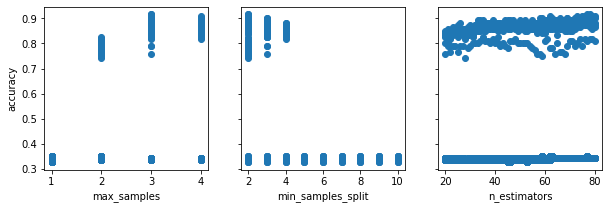

In [19]:
# visualize mean test score as a function of hyperparameters
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(10, 3))
ax1.scatter(cvres.param_max_samples, cvres['mean_test_score'])
ax1.set_xlabel('max_samples')
ax1.set_ylabel('accuracy')
ax2.scatter(cvres.param_min_samples_split, cvres['mean_test_score'])
ax2.set_xlabel('min_samples_split')
ax3.scatter(cvres.param_n_estimators, cvres['mean_test_score'])
ax3.set_xlabel('n_estimators')
fig.show()

In [37]:
# predict with best model found in cross-validation
ypred = clf.predict(Xtest)

# compute precision and recall for all species
prec = precision_score(ytest, ypred, average=None)
rec = recall_score(ytest, ypred, average=None)

# print accuracy on hold-out set
print('Accuracy = %.3f' %(clf.score(Xtest, ytest)))
print('Precision (setosa, versicolor, virginica) = %.3f, %.3f, %.3f' %(prec[0], prec[1], prec[2]))
print('Recall (setosa, versicolor, virginica) = %.3f, %.3f, %.3f' %(rec[0], rec[1], rec[2]))

Accuracy = 0.833
Precision (setosa, versicolor, virginica) = 1.000, 0.667, 1.000
Recall (setosa, versicolor, virginica) = 1.000, 1.000, 0.500
